In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, \
                                    Conv2DTranspose, BatchNormalization, Dropout, Flatten, \
                                    Embedding, multiply, Add, LeakyReLU, Dense, Reshape, \
                                    Activation, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import pandas as pd
import os
import joblib
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from tqdm.notebook import tqdm

In [2]:
reset_model_training = False
proj_path = os.getcwd()
mdl_chkpt_path = os.path.join(proj_path,"mdl_chkpt")
mdl_progress_fold = os.path.join(proj_path,"progress")

if reset_model_training:
    model_train_details = {
    "epoch_dict" : {"initial_epoch":0},
    "past_history" : {},
    "last_checkpoint":None    
    }
    joblib.dump(model_train_details,"model_train_details")
    
    if "mdl_chkpt" not in os.listdir(proj_path):
        os.mkdir(mdl_chkpt_path)
    
    if "progress" not in os.listdir(proj_path):
        os.mkdir(mdl_progress_fold)
    
    
    mdl_chk_files = os.listdir(mdl_chkpt_path)
    prog_files = os.listdir(mdl_progress_fold)
    
    print(f"deleting contents of {mdl_chkpt_path}")
    print(f"deleting contents of {mdl_progress_fold}")
    
    for f in mdl_chk_files:
        os.remove(os.path.join(mdl_chkpt_path,f))
    
    for f in prog_files:
        os.remove(os.path.join(mdl_progress_fold,f))

In [3]:
(x_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
x_train.shape,y_train.shape

((60000, 28, 28), (60000,))

In [4]:
x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_train.shape,y_train.shape

((60000, 28, 28, 1), (60000,))

In [5]:
def build_generator(num_classes=10, latent_dim = 100):
    
    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = (Embedding(num_classes, latent_dim)(label))
    model_input = Add()([noise, label_embedding])
    
    x = Dense(7 * 7 * 128)(model_input)
    x = Reshape((7, 7, 128))(x)
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(1, kernel_size=7, strides=1, padding='same')(x)
    
    model_output = Activation('sigmoid')(x)                                        
    model = Model(inputs=[noise,label], outputs=[model_output],name="generator")
    
    return model

In [6]:
def build_discriminator(img_shape=(28,28,1), n_classes=10):
    img = Input(shape=img_shape)
    x = Conv2D(64, kernel_size=3, strides=2, padding='same')(img)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    model_output = Dense(1, activation='softmax')(x)
    
    model = Model(inputs=img, outputs=model_output,name="discriminator")
    
    return model

In [7]:
gen_model = build_generator()
disc_model = build_discriminator()

In [8]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_optimizer = tf.keras.optimizers.Adam()
        self.disc_optimizer = tf.keras.optimizers.Adam()
        self.checkpoint = tf.train.Checkpoint( generator=self.generator,
                                               discriminator=self.discriminator,
                                               gen_optimizer=self.gen_optimizer,
                                               disc_optimizer=self.disc_optimizer)

    def compile(self, gen_optimizer, disc_optimizer):
        self.gen_optimizer = gen_optimizer
        self.disc_optimizer = disc_optimizer

    def save_checkpoint(self, checkpoint_dir):
        self.checkpoint.save(file_prefix=checkpoint_dir)

    def load_checkpoint(self, checkpoint_dir):
        self.checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

    @staticmethod
    def generator_loss(fake_out_disc_pred):
        return tf.reduce_mean(tf.keras.losses.binary_crossentropy(
                                       tf.ones_like(fake_out_disc_pred), fake_out_disc_pred))

    @staticmethod
    def discriminator_loss(real_out_disc_pred, fake_out_disc_pred):
        real_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(tf.ones_like(real_out_disc_pred), 
                                                     real_out_disc_pred))
        fake_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_out_disc_pred), 
                                                     fake_out_disc_pred))
        total_loss = real_loss + fake_loss
        return total_loss
    
    @tf.function
    def train_step(self, noise,label, real_images):
        
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            
            generated_images = self.generator([noise,label], training=True)

            real_out_disc_pred = self.discriminator(real_images, training=True)
            fake_out_disc_pred = self.discriminator(generated_images, training=True)
            
            gen_loss = self.generator_loss(fake_out_disc_pred)
            disc_loss = self.discriminator_loss(real_out_disc_pred, fake_out_disc_pred)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.gen_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.disc_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        return gen_loss, disc_loss

In [9]:
model_train_details = joblib.load("model_train_details")
init_epoch = model_train_details.get("epoch_dict").get("initial_epoch") 
past_hist = model_train_details.get("past_history")
last_chkpt = model_train_details.get("last_checkpoint")
past_gen_loss = model_train_details.get("past_history").get("generator_loss",[])
past_disc_loss = model_train_details.get("past_history").get("discriminator_loss",[])

gan = GAN(discriminator=disc_model, generator=gen_model)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gan.compile(gen_optimizer, disc_optimizer)

if init_epoch>0 and last_chkpt is not None:
    print("loading last checkpoint")
    gan.load_checkpoint(os.path.join(mdl_chkpt_path,last_chkpt))
        

loading last checkpoint


In [10]:
x_train[:32].shape,y_train[:32].shape

((32, 28, 28, 1), (32,))

In [11]:
batch_size = 64
epochs = 20
total_num_data = x_train.shape[0]
num_batches = total_num_data//batch_size

In [12]:
for epoch in tqdm(range(init_epoch,init_epoch+epochs)):
    for i in range(num_batches):
        noise = tf.random.normal(shape=(batch_size, 100))
        real_images = x_train[i * batch_size : (i + 1) * batch_size]
        labels = y_train[:batch_size]
        
        gen_loss, disc_loss = gan.train_step(noise, labels, real_images)
        gen_loss = gen_loss.numpy()
        disc_loss = disc_loss.numpy()
        
    print(f"epoch {epoch+1} : generator loss: {gen_loss}, discriminator loss: {disc_loss}")
    
    last_chpt_file = os.path.join(mdl_chkpt_path,f"mdl_chkpt_{epoch+1}.h5")
    past_gen_loss.append(gen_loss)
    past_disc_loss.append(disc_loss)
    
    past_hist = {
        "epoch":epoch+1,
        "generator_loss":past_gen_loss,
        "discriminator_loss":past_disc_loss
    }

    model_train_details = {
                            "epoch_dict" : {"initial_epoch":epoch+1},
                            "past_history" : past_hist,
                            "last_checkpoint" : last_chpt_file
                            }

    joblib.dump(model_train_details,"model_train_details")
    if epoch==init_epoch+epochs-1:
        gan.save_checkpoint(last_chpt_file)

  0%|          | 0/20 [00:00<?, ?it/s]

epoch 31 : generator loss: 1.429593563079834, discriminator loss: 0.9072022438049316
epoch 32 : generator loss: 1.3994578123092651, discriminator loss: 0.8336672186851501
epoch 33 : generator loss: 1.0005652904510498, discriminator loss: 0.9110848903656006
epoch 34 : generator loss: 1.0310792922973633, discriminator loss: 0.9352817535400391
epoch 35 : generator loss: 2.0017752647399902, discriminator loss: 0.781467080116272
epoch 36 : generator loss: 1.753026008605957, discriminator loss: 0.7681113481521606
epoch 37 : generator loss: 1.2165037393569946, discriminator loss: 0.7245205044746399
epoch 38 : generator loss: 1.8500410318374634, discriminator loss: 0.6802171468734741
epoch 39 : generator loss: 1.7557791471481323, discriminator loss: 0.6436911225318909
epoch 40 : generator loss: 1.4934712648391724, discriminator loss: 0.6828000545501709
epoch 41 : generator loss: 1.9257713556289673, discriminator loss: 0.6510758399963379
epoch 42 : generator loss: 2.1633048057556152, discrimina

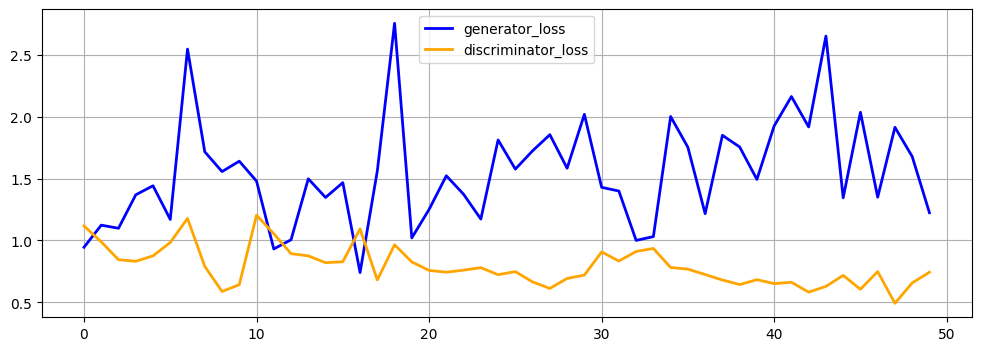

In [13]:
plt.figure(figsize=(12,4))
plt.plot(model_train_details.get("past_history").get("generator_loss"),color="blue",
            linewidth=2)
plt.plot(model_train_details.get("past_history").get("discriminator_loss"),color="orange",
            linewidth=2)

plt.legend(["generator_loss","discriminator_loss"])
plt.grid(True);

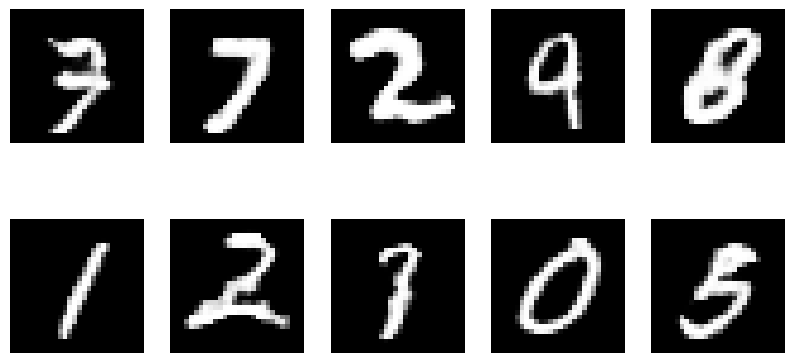

In [14]:
plt.figure(figsize=(10,5))
for k in range(1,11):
    
    noi = tf.random.normal(shape=(1,100))
    lab = tf.convert_to_tensor([y_train[k]])
    pred = gen_model([ noi, lab ])[0]
    
    plt.subplot(2,5,k)
    plt.imshow(pred,cmap="gray")
    plt.axis("off");
    
plt.savefig(f"progress/pred_{epoch}")    